In [2]:
import pandas as pd
import numpy as np
import pyspark as ps
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [3]:
rating_dt = pd.read_csv('../data/ratings.csv')

In [4]:
#tag_dt = pd.read_csv('tags.csv')

In [7]:
#movie_dt = pd.read_csv('movies.csv')

In [17]:
#print(tag_dt.head(5))
print(rating_dt.head(5))
#print(movie_dt.head(5))

   userId  movieId  rating   timestamp
0       1      307     3.5  1256677221
1       1      481     3.5  1256677456
2       1     1091     1.5  1256677471
3       1     1257     4.5  1256677460
4       1     1449     4.5  1256677264


In [3]:
rating_dt.shape

(27753444, 4)

### Sample Data
choose movies that have been rated for over 100 times

In [4]:
# filter out movies that has less than 100 rates
movie_rating_count = rating_dt.groupby(['movieId']).size().reset_index(name='Mcount')
movie_poll = movie_rating_count[movie_rating_count.Mcount > 100].movieId

In [5]:
# sample 1000 items from movie poll 
movie_sample = movie_poll.sample(1000, replace=False, random_state=1).values.reshape(-1, 1)

# get rating and users of sampled movies
sample_movie_rating = rating_dt.loc[rating_dt['movieId'].isin(movie_sample)]

In [6]:
# sample 1000 users 
user_poll = np.unique(sample_movie_rating['userId'])
np.random.seed(1)
user_test = np.random.choice(user_poll, 1000)
test_user_rating = sample_movie_rating.loc[sample_movie_rating['userId'].isin(user_test)]

### KNN Collaborative Filtering

In [8]:
# pivot movie, user, rating dataframe into compressed matrix
#
def movie_use_matrix_pivot(df_):
    mu_matrix = df_.pivot(index = 'movieId', 
                          columns = 'userId', 
                          values = 'rating').fillna(0)
    # compress original matrix
    mu_matrix_cp = csr_matrix(mu_matrix.values)
    return mu_matrix, mu_matrix_cp

In [9]:
# input: compressed movie-user matrix, distance method, number of nearest neighbors
# default distance method is adjusted cosine, default neighbor is 5
# output: a pre-trained KNN model
#
def knn_model_fit(mu_matrix_cp, dist_='cosine', n_neighbor_=5):
    # use adjusted cosine distance to find k nearest item 
    # default k-neighbor is 5
    knn = NearestNeighbors(metric=dist_, algorithm='brute', n_neighbors=n_neighbor_, n_jobs=-1)
    knn.fit(mu_matrix_cp)
    return knn

In [10]:
# input: a pre-trained KNN model (n_neighbor = 5), movie-user matrix, one movieid
# output: a list of distance of nearest neighbors, a list of indices of nearest neighbors
# to movie-user matrix
#
def single_recommendation(knn_model, mu_matrix, movieid):
    movie_input = mu_matrix.loc[mu_matrix.index == movieid]
    distance, indices = knn_model.kneighbors(movie_input)
    return distance, indices   

In [13]:
# test function
sample_matrix, sample_matrix_cp = movie_use_matrix_pivot(test_user_rating)
sample_matrix_knn = knn_model_fit(sample_matrix_cp, 'cosine', 5)

distance1, indices1 = sample_matrix_knn.kneighbors(sample_matrix.loc[sample_matrix.index == 34])
distance2, indices2 = single_recommendation(sample_matrix_knn, sample_matrix, 34)
assert(np.alltrue(indices1 == indices2))

In [14]:
# input: rating dataset, userid, a rating threshold, movies that are rated below threshold
# will not be counted 
# output: a list of high-scored movies that are rated by givern user, a list of corresponding ratings
#
def get_rated_movies(data, userid, threshold=2):
    all_rates = data[data['userId'] == userid]
    high_rates = all_rates[all_rates['rating'] >= threshold]['rating'].values
    high_rate_movie = all_rates[all_rates['rating'] >= threshold]['movieId'].values
    return high_rate_movie, high_rates

In [15]:
# input: pre-trained KNN model, movie-user matrix of historical data, 
# a list of movies that have been rated by given user, corresponding ratings
# output: if number of rated movies < 5, return list of 5 * n recommendation
# if number of rated movies > 5, return list of 20 recommendation base on rating itself
# and 5 nearest neighbors
#
def mult_recommendation(knn_model, mu_matrix, ratedmovies, ratings):
    indices_list = []
    distance_list = []
    recommend_list = []
    
    for count, i in enumerate(ratedmovies):
        distance, indices = single_recommendation(knn_model, mu_matrix, i)
        indices_list.extend(indices.reshape(-1))
        # adjust distance by rating
        distance_adj = (distance.reshape(-1) / ratings[count]).tolist()
        # find corresponding movieid
        movie_list = mu_matrix.index[indices.reshape(-1)].tolist()
        # delete if same movieid exist in recommendation list
        if movie_list[0] == i:
            movie_list = movie_list[1:]
            distance_adj = distance_adj[1:]

        distance_list.extend(distance_adj)
        recommend_list.extend(movie_list)
    
    recommend_list = np.array(recommend_list)
    
    if recommend_list.shape[0] <= 20:
        return recommend_list
    else:
        sorted_recommend = recommend_list[np.array(distance_list).argsort()]
        # choose top 20 recommendations
        return sorted_recommend[:20]

In [16]:
# test function (small dataset)
movies, ratings = get_rated_movies(test_user_rating, 281940, 2)
res = mult_recommendation(sample_matrix_knn, sample_matrix, movies, ratings)
print(movies)
print(res)
print('recommendation list is of length', len(res))

[  47  301  309  431  509  920  934 1066 1089 1198 1293 1357 1358 1682
 2324 3159 4011 4019 4973 5299 5445 7153]
[4011   47 2542 6874 1198 2542 1222 5445 4011 4973 1387 1500 7153 1089
 5445  515 1527 1387 1089 2302]
recommendation list is of length 20


### Matrix Factorization Collaborative Filtering 

In [8]:
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.sql import SparkSession

import seaborn as sns
import matplotlib.pyplot as plt

# initialize spark session
spark = SparkSession.builder.appName('ieor-hw2').getOrCreate()

In [9]:
# transform pandas df to spark df   --- long run time
test_user_rating_spark = spark.createDataFrame(test_user_rating)
sample_movie_rating_spark = spark.createDataFrame(sample_movie_rating)

In [10]:
# Create ALS model
als = ALS(
         userCol="userId", 
         itemCol="movieId",
         ratingCol="rating", 
         nonnegative = True, 
         implicitPrefs = False,
         coldStartStrategy="drop"
)

### Cross Validation Setup
5-fold CV on dataset of 1000 movies and 2.6 million ratings <br>
use RMSE as scoring metric, and search for best 'rank'

In [12]:
# train-test split on large dataset 
(train_big,test_big) = sample_movie_rating_spark.randomSplit([0.80, 0.20], seed=15)
# train-test split on small sample data
(train_small,test_small) = test_user_rating_spark.randomSplit([0.80, 0.20], seed=15)

In [174]:
# setup grid search parameters 
# test value of hyperparameter 'rank' from 2, 4, 6, 8, 10, 12, 14
para_grid = ParamGridBuilder() \
                .addGrid(als.rank, range(2, 15, 2))  \
                .build()

# use rmse as scoring metric
evaluator = RegressionEvaluator(metricName='rmse', 
                                labelCol='rating', 
                                predictionCol='prediction')

# setup validation function 
tvs = TrainValidationSplit(estimator = als, 
                           estimatorParamMaps = para_grid, 
                           evaluator = evaluator, 
                           seed=1)

In [175]:
# fit on big data set   --- long run time
model = tvs.fit(train_big)

Text(0.5, 1.0, 'CV-curve of MF Rank')

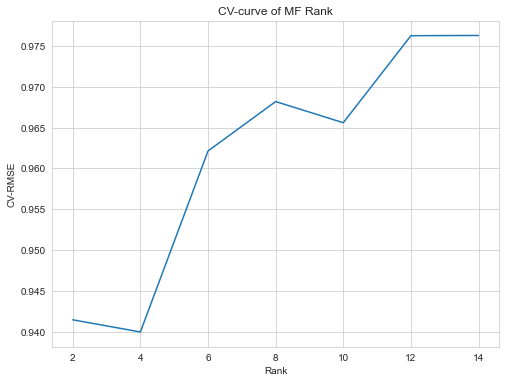

In [176]:
# visualize performance on validation set for each value of rank
ax, fig = plt.subplots(figsize=(8, 6))
sns.set_style("whitegrid")
plt.plot(range(2, 15, 2), model.validationMetrics)
plt.xlabel('Rank')
plt.ylabel('CV-RMSE')
plt.title('CV-curve of MF Rank')

In [13]:
# uncomment to save model for future use
## best.save('als_model')

# uncomment to train from data with best hyperparameters 
## als_2 = als.setRank(4)
## best = als_2.fit(train_big)

In [308]:
# best model has rank 4, iteration 10 (default), regularization parameter 0.1 (default)
best = model.bestModel

predictions = best.transform(test_small)
rmse = evaluator.evaluate(predictions)

print("RMSE: " + str(rmse))
print("***BestModel***")
print("  rank: " + str(best.rank))
print("  MaxIter: " + str(best._java_obj.parent().getMaxIter()))
print("  RegParam: " + str(best._java_obj.parent().getRegParam()))

RMSE: 0.7658987305990971
***BestModel***
  rank: 4
  MaxIter: 10
  RegParam: 0.1


### MF Model RMSE on Test and Train 100% Dataset

In [71]:
test_pred = best.transform(test_big)
test_rmse = evaluator.evaluate(test_pred)

In [24]:
train_pred = best.transform(train_big)
train_rmse = evaluator.evaluate(train_pred)

In [72]:
print("Test RMSE: " + str(test_rmse))
print("Train RMSE: " + str(train_rmse))

Test RMSE: 0.9115554536168751
Train RMSE: 0.7048404634761517


### Matrix Factorization Recommender Funtion

In [16]:
# input: a pre-trained mf model, rating data (spark df), number of recommendations for each user
# output: a dict of recommendations sorted descending by predicted rating, key by userid
#
def MF_recommendation(mf_model, data, rec_number=20):
    predictions = mf_model.transform(data)
    user_recommendation = mf_model.recommendForUserSubset(data, rec_number).toPandas()
    rec_dict = {}
    
    for i in range(0, user_recommendation.shape[0]):
        userid = user_recommendation.iloc[i, 0]
        movieid = [item[0] for item in user_recommendation.iloc[i, 1]]
        rec_dict[userid] = movieid
    
    return rec_dict

In [31]:
# test function (sample dataset)
rec = MF_recommendation(best, test_small)

In [43]:
# iterate through dictionary
# for purpose of display recommendation
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [52]:
first_5 = take(5, rec.items())
first_5
for pair in first_5:
    print(f'userId: {pair[0]}')
    print(f'recommend movies: {pair[1]}')

userId: 231287
recommend movies: [5224, 7153, 4973, 771, 86504, 5772, 800, 72104, 50742, 2324, 1357, 515, 171011, 3920, 58425, 1293, 103867, 1295, 1358, 72226]
userId: 243392
recommend movies: [171011, 159819, 1198, 167832, 47, 121374, 119153, 48516, 112556, 147330, 65133, 73681, 55721, 96488, 4011, 6808, 116411, 86504, 2324, 89492]
userId: 37482
recommend movies: [171011, 159819, 5224, 4973, 86504, 50742, 147330, 58425, 2324, 1212, 720, 750, 3134, 800, 951, 26903, 177765, 1293, 1284, 7153]
userId: 115225
recommend movies: [2324, 191351, 93265, 51471, 177765, 167832, 54001, 6970, 106441, 86504, 170697, 87308, 94503, 134374, 91844, 116855, 106696, 89554, 117176, 103867]
userId: 162241
recommend movies: [7153, 171011, 4011, 2542, 91529, 121374, 86504, 47, 106873, 48516, 2324, 1080, 1089, 70286, 3949, 171253, 159819, 4973, 119153, 1357]


### Precision, Recall, Coverage Functions

In [53]:
# input: rating data (spark df), split point (default 2)
# rating 5, 4, 3 will be considered as positive (as default)
# rating 1, 2 will be considered as negative (as default)
# output: dict of positively rated movie key by user, dict of negative rated movie key by user
#
def positive_negative_split(spdf, threshold=2):
    user_rate_df = spdf.toPandas()
    pos_dict = {}
    neg_dict = {}
    
    for user in np.unique(user_rate_df.userId):
        all_rates = user_rate_df[user_rate_df['userId'] == user]
        positive_rates = all_rates[all_rates['rating'] > threshold]['movieId'].tolist()
        negative_rates = all_rates[all_rates['rating'] <= threshold]['movieId'].tolist()
        pos_dict[user] = positive_rates
        neg_dict[user] = negative_rates
        
    return pos_dict, neg_dict

In [21]:
# test function 
pos, neg = positive_negative_split(test_big)

In [19]:
# input: pre-trained MF model, new rating data (spark df), split point (default 2)
# predicted rating > 2.5 will be predicted as positive 
# predicted rating < 2.5 will be predicted as negative 
# output: recall and precision of pre-trained MF model on given data set
#
def precision_recall_cal(mf_model, data, threshold=2):
    pos, neg = positive_negative_split(data, threshold)
    predictions = mf_model.transform(data).toPandas()
    tp = 0
    fp = 0
    p_total = 0
    
    for user in pos:
        for rated in pos[user]:
            pred = predictions.loc[(predictions.userId == user) & (predictions.movieId == rated),
                                   'prediction'].tolist()
            if pred:
                p_total += 1
                if pred[0] >= threshold + 0.5:
                    tp += 1
    
    for user in neg:
        for rated in neg[user]:
            pred = predictions.loc[(predictions.userId == user) & (predictions.movieId == rated), 
                                   'prediction'].tolist()
            if pred:
                if pred[0] >= threshold + 0.5:
                    fp += 1
    
    recall = tp / p_total
    precision = tp / (tp + fp)
    
    return recall, precision

In [56]:
# test function (sample dataset)
precision_recall_cal(best, test_small, 2)

(0.9635523613963038, 0.9310515873015873)

In [58]:
#train_recall, train_prec = precision_recall_cal(best, train_big, 2)  --- long run time
test_recall, test_prec = precision_recall_cal(best, test_big, 2)

In [59]:
#print(f'Recall on training set: {train_recall}')
#print(f'Precision on training set: {train_prec}')
print(f'Recall on testing set: {test_recall}')
print(f'Precision on testing set: {test_prec}')

Recall on testing set: 0.9396966422365336
Precision on testing set: 0.9148965505538375


In [14]:
# calculate number of covered recommendations
def coverage_cal(mf_model, data, rec_number = 20):
    rec_dic = MF_recommendation(mf_model, data, rec_number)
    rec_values = rec_dic.values()
    rec_unique = set()
    
    for item in rec_values:
        rec_unique.update(item)
    
    return len(rec_unique)

In [20]:
# calculate coverage on big data set   --- long run time
train_cover = coverage_cal(best, train_big)
print(f'Recommendation list covered {train_cover}')

Recommendation list covered 308


### Model Evaluation on Different Size of Data

In [60]:
# random select 25%, 50%, 75% from big dataset 
movie_ratings_25 = sample_movie_rating.sample(frac = .25, random_state = 1)
movie_ratings_50 = sample_movie_rating.sample(frac = .50, random_state = 2)
movie_ratings_75 = sample_movie_rating.sample(frac = .75, random_state = 3)

In [63]:
# convert to spark-df  --- long run time
movie_rating_25_sp = spark.createDataFrame(movie_ratings_25)
movie_rating_50_sp = spark.createDataFrame(movie_ratings_50)
movie_rating_75_sp = spark.createDataFrame(movie_ratings_75)

# train-test split 
(train_25,test_25) = movie_rating_25_sp.randomSplit([0.80, 0.20], seed=1)
(train_50,test_50) = movie_rating_50_sp.randomSplit([0.80, 0.20], seed=1)
(train_75,test_75) = movie_rating_75_sp.randomSplit([0.80, 0.20], seed=1)

In [66]:
als_2 = als.setRank(4)

In [65]:
# fit mf model on 75% data, rank = 4
model_75 = als_2.fit(train_75)
model_50 = als_2.fit(train_50)
model_25 = als_2.fit(train_25)

In [68]:
# calculate rmse on both testing and training 
pred_75_train = model_75.transform(train_75)
pred_75_test = model_75.transform(test_75)
eva_75_train = evaluator.evaluate(pred_75_train)
eva_75_test = evaluator.evaluate(pred_75_test)

pred_50_train = model_50.transform(train_50)
pred_50_test = model_50.transform(test_50)
eva_50_train = evaluator.evaluate(pred_50_train)
eva_50_test = evaluator.evaluate(pred_50_test)

pred_25_train = model_50.transform(train_25)
pred_25_test = model_50.transform(test_25)
eva_25_train = evaluator.evaluate(pred_25_train)
eva_25_test = evaluator.evaluate(pred_25_test)

In [73]:
size_rmse_test = [eva_25_test, eva_50_test, eva_75_test, test_rmse]
size_rmse_train = [eva_25_train, eva_50_train, eva_75_train, train_rmse]

In [75]:
# calculate precision and racall on testing  --- long run time
test_25_recall, test_25_prec = precision_recall_cal(model_25, test_25, 2)
test_50_racall, test_50_prec = precision_recall_cal(model_50, test_25, 2)
test_75_recall, test_75_prec = precision_recall_cal(model_75, test_75, 2)

In [76]:
size_prec_test = [test_25_prec, test_50_prec, test_75_prec, test_prec]
size_recall_test = [test_25_recall, test_50_racall, test_75_recall, test_recall]

In [117]:
size_df = pd.DataFrame(size_rmse_test, index=['25%', '50%', '75%', '100%'], columns=['rmse_test'])
size_df['rmse_train'] = size_rmse_train
size_df['prec_test'] = size_prec_test
size_df['recall_test'] = size_recall_test

Text(0.5, 1.0, 'Recall on Testing')

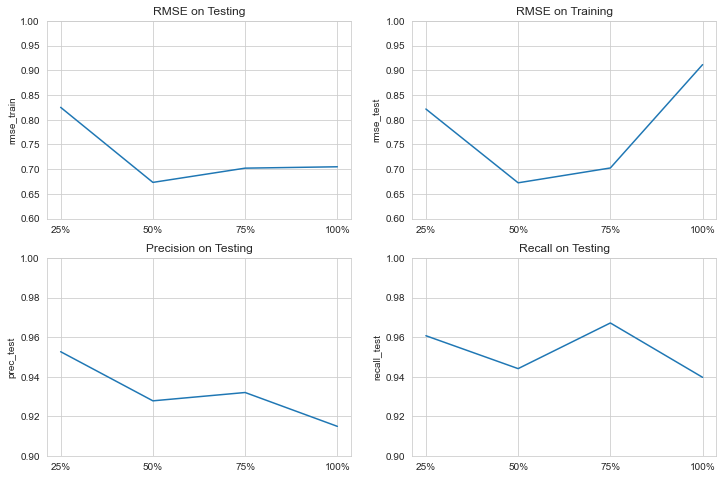

In [184]:
# visualize model evaluation on different size
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.lineplot(data=size_df.rmse_train, ax=axes[0, 0])
sns.lineplot(data=size_df.rmse_test, ax=axes[0, 1])
sns.lineplot(data=size_df.prec_test, ax=axes[1, 0])
sns.lineplot(data=size_df.recall_test, ax=axes[1, 1])

axes[0, 1].set_ylim([0.6, 1])
axes[0, 0].set_ylim([0.6, 1])
axes[1, 0].set_ylim([0.9, 1])
axes[1, 1].set_ylim([0.9, 1])

axes[0, 0].set_title('RMSE on Testing')
axes[0, 1].set_title('RMSE on Training')
axes[1, 0].set_title('Precision on Testing')
axes[1, 1].set_title('Recall on Testing')